# Lab 8 & 9 - fMNIST Classification with Dense Neural Networks (using Tensorflow)

## Introduction

The goal is to develop and train a three different fully connected neural network models with different hyperparameters to recognize/classify clothing items belonging to 10 different classes. We have to find the best model with best weights among the three and evaluate the performance on the best model. We are going to use fMNIST dataset which consists of 60,000 images in the training dataset and 10,000 images in testing dataset. In Total there are 70,000 images. The images are represented as pixels. There are around 784 features representing the pixel values. Each image corresponds to a pixel array of 28X28. The dataset has 10 classes as follows
* 0 T-shirt/top
* 1 Trouser
* 2 Pullover
* 3 Dress
* 4 Coat
* 5 Sandal
* 6 Shirt
* 7 Sneaker
* 8 Bag
* 9 Ankle boot 

In [133]:
# Importing the libraries
from tensorflow.keras.datasets import fashion_mnist
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import pandas as pd
from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, recall_score, f1_score,classification_report,precision_recall_curve

In [2]:
# Importing the fMNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Data Exploration

The images are represented as 28X28 pixel arrays with pixel values ranging from 0 to 255.

In [3]:
# Checking the Dtype, shape, minimum and maximum value of training and testing images
print(f' Training Image DType: {type(train_images)}')
print('**Shapes:**')
print('Train Data:')
print(f'Images: {train_images.shape}')
print(f'Labels: {train_labels.shape}')
print('Test Data:')
print(f'Images: {test_images.shape}')
print(f'Labels: {test_labels.shape}')
print('Image Data Range:')
print(f'Min: {train_images.min()}')
print(f'Max: {train_images.max()}')

 Training Image DType: <class 'numpy.ndarray'>
**Shapes:**
Train Data:
Images: (60000, 28, 28)
Labels: (60000,)
Test Data:
Images: (10000, 28, 28)
Labels: (10000,)
Image Data Range:
Min: 0
Max: 255


### Displaying the first 100 images of mnist dataset with corresponding class labels

In [4]:
# Creating a list of label description
label_description = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

In [5]:
# Function to plot the images of fMNIST dataset with corresponding labels
def plot_images(image_data,label):
    plt.imshow(image_data, cmap="binary")
    plt.title(f"{label}-{label_description[label]}", fontsize=8)
    plt.axis("off")

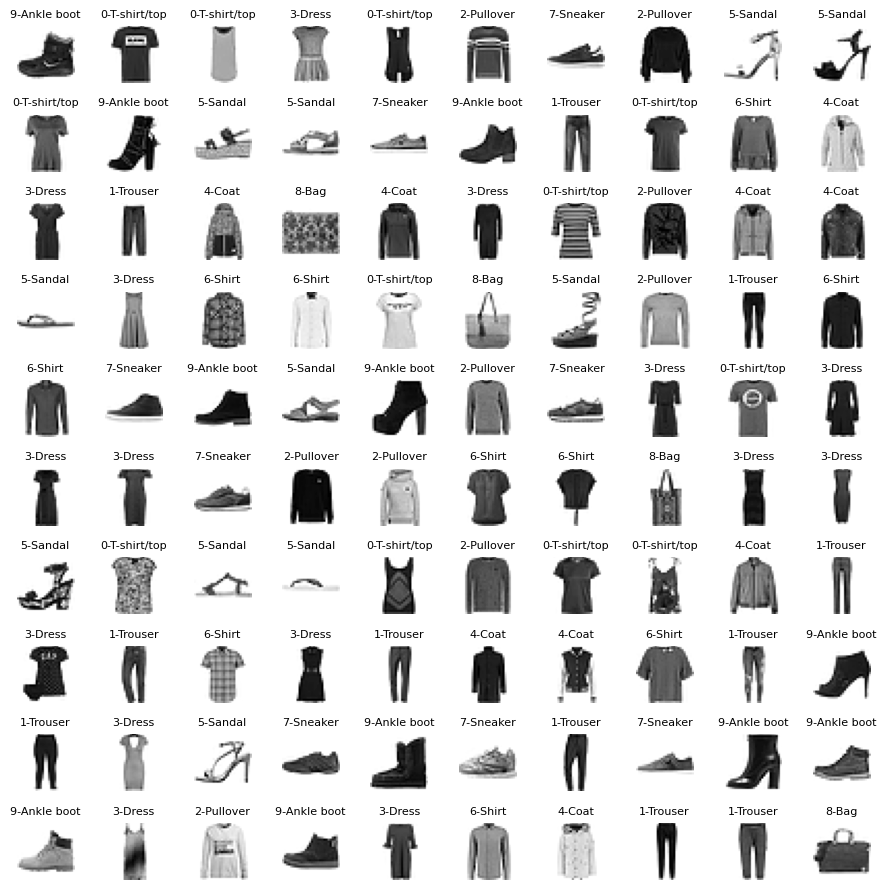

In [6]:
# Displaying the first 100 images along with class description 
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(train_images[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_images(image_data,train_labels[idx])
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()

### Visualizing the pixels of first input image from training set

The images are represented in grayscale with pixel values ranging from 0 to 255. pixel value of 0-corresponds to black and 255 - white

In [7]:
# Function to visualize the pixel values of an image
def visualize_input(i, ax, y):
    img = train_images[i]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{train_labels[i]}-{label_description[train_labels[i]]}")
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(img[x][y]), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')
    ax.set_xticks([])
    ax.set_yticks([])

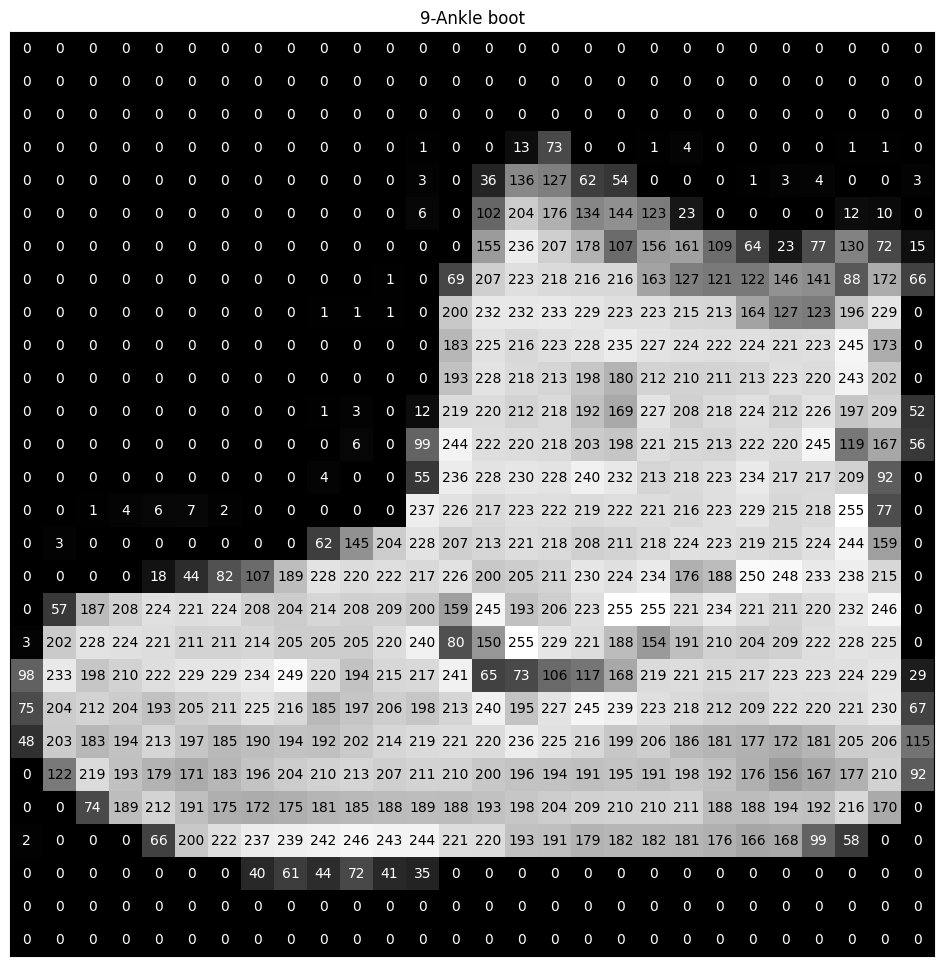

In [8]:
# Plotting the pixel value of the first image
for i in range(1):
    fig = plt.figure(figsize = (12,12)) 
    ax = fig.add_subplot(111)
    visualize_input(i, ax, train_labels)

### Piechart to show the class distribution/skewness of the dataset

The images are **equally distributed across classes**. There are **6000 images for each class**. And the dataset has **0 skewness**. 

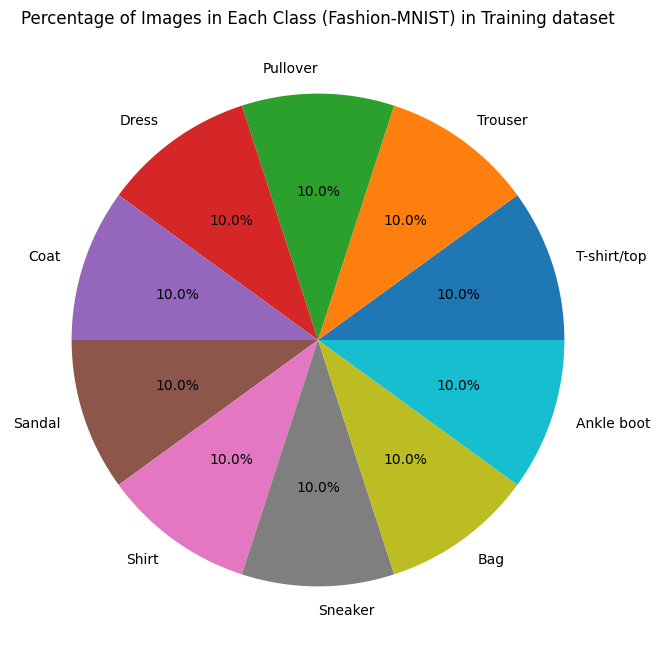

In [9]:
# Count the occurrences of each class
class_counts = np.bincount(train_labels)
# Plot a piechart using matplotlib
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=label_description, autopct='%1.1f%%')
plt.title('Percentage of Images in Each Class (Fashion-MNIST) in Training dataset')
plt.show()


### Pixel value distribution of an image

The below histogram shows the intensity of pixel values. The **maximum pixel values** are **0-black**. The **most dominant pixel values** are **black and grey pixels**.

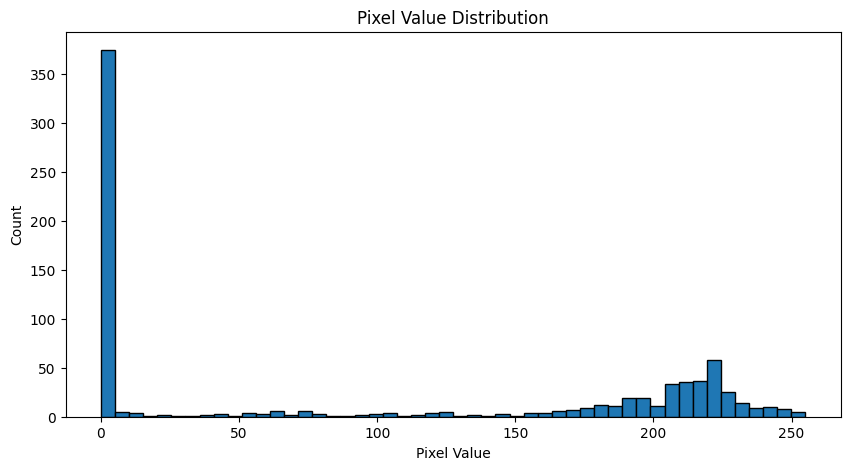

In [10]:
# Plot the distribution of pixel values - First image in training dataset
fig = plt.figure(figsize=(10, 5))
plt.hist(train_images[0].flatten(), bins=50, edgecolor='black')
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Count')
plt.show()

### Average image per class

* The below plot calculates and shows the **average image for the current class by taking the mean of all images corresponding to that class**. * From the plot, we are **able to clearly identify the structure of T-shirt,Trouser,Dress,ankle boot**. 
* But the **structures/features of pullover,coat and shirt are somewhat similar**. So, **the model might find it difficult to classify these clothing**.
* Also, the **features of sandal and bag is not clear** from the average image. 

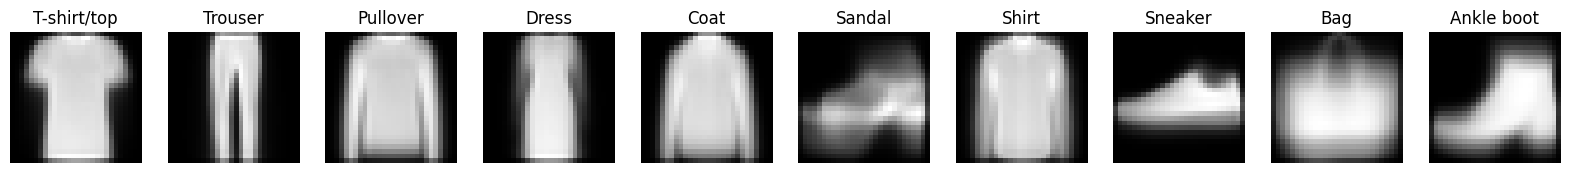

In [11]:
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for image in range(10):
    image_indices = np.where(train_labels == image)[0]
    avg_image = np.mean(train_images[image_indices], axis=0)
    axes[image].imshow(avg_image, cmap='gray')
    axes[image].set_title(label_description[image])
    axes[image].axis('off')
plt.show()

## Data Pre-Processing

### Splitting the Training dataset into training and validation set

Now out of **60000 images in training dataset**, we have split the dataset into **training dataset - 48,000 images** and **validation dataset - 12,000 images**. The **testing dataset contains 10,000 images**.

In [12]:
# Initializing the training size
training_size = 0.80
# getting the total number of rows
total_rows = train_images.shape[0]
train_size = int(total_rows*training_size)
 
# Split image data into validation and training
train_img = train_images[0:train_size]
val_images = train_images[train_size:]

# Splitting the labels into training and validation
train_labl = train_labels[0:train_size]
val_labels = train_labels[train_size:]

In [13]:
# Flattening the 28x28 image into dim=1 (784,) vector
train_img = train_img.reshape((48000, 28 * 28)) 
val_images = val_images.reshape((12000, 28 * 28)) 
test_images = test_images.reshape((10000, 28 * 28))

# normalizing the data to the range [0,1] by min-max range, and casting it to float32
train_img = train_img.astype("float32") / 255
val_images = val_images.astype("float32") / 255
test_images = test_images.astype("float32") / 255

## Modeling

Here We are going to define three models

1. **Model 1**
  - Model 1 has the following structure **1-input layer which consists of 128 neurons** and **1 - hidden layer** and **1-output layer** which has **10 output neurons representing each class**. 
  - **All the layers are fully-connected**. 
  - The **activation function** is **Rectified Linear unit and Softmax**. Also we are using **adam optimizer** and **sparse categorical cross-entropy as loss function**. 
  - We have given **epochs as 10** and **batch size is 128**. Total **training steps** per epoch is **375**. 
  - We got a **accuracy of 90.94% on the training dataset and 88.88% accuracy on the validation dataset after 10 epochs**.
  - The total **number of trainable parameters for model 1 is 118,282**

In [56]:
def modelcheckpoint_callback(checkpoint_filepath):
    return ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  # Optionally save only weights instead of the full model
    monitor='val_loss',
    mode='min',  # Monitor validation loss and save on minimum
    save_best_only=True)

In [57]:
models = []
model_history = []

In [58]:
# Defining a simple dense neural network
model_1_three_layers = keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [59]:
# compiling the model 
model_1_three_layers.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [60]:
# Fitting the model to the training dataset
history_1 = model_1_three_layers.fit(train_img, train_labl, epochs=10, batch_size=128,validation_data = (val_images,val_labels),callbacks=[modelcheckpoint_callback("best_model1.hdf5")])

Epoch 1/10


375/375 [==============================] - 4s 6ms/step - loss: 0.5726 - accuracy: 0.8002 - val_loss: 0.4221 - val_accuracy: 0.8512
Epoch 2/10
375/375 [==============================] - 2s 5ms/step - loss: 0.3985 - accuracy: 0.8591 - val_loss: 0.3758 - val_accuracy: 0.8643
Epoch 3/10
375/375 [==============================] - 2s 5ms/step - loss: 0.3496 - accuracy: 0.8747 - val_loss: 0.3730 - val_accuracy: 0.8657
Epoch 4/10
375/375 [==============================] - 2s 5ms/step - loss: 0.3253 - accuracy: 0.8809 - val_loss: 0.3420 - val_accuracy: 0.8749
Epoch 5/10
375/375 [==============================] - 2s 5ms/step - loss: 0.3048 - accuracy: 0.8877 - val_loss: 0.3451 - val_accuracy: 0.8756
Epoch 6/10
375/375 [==============================] - 2s 5ms/step - loss: 0.2892 - accuracy: 0.8933 - val_loss: 0.3250 - val_accuracy: 0.8830
Epoch 7/10
375/375 [==============================] - 2s 5ms/step - loss: 0.2767 - accuracy: 0.8973 - val_loss: 0.3403 - val_accuracy: 0.8768
Epoch 8/10
375/37

In [61]:
models.append(model_1_three_layers)
model_history.append(history_1)

In [62]:
model_1_three_layers.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 128)               100480    
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                                                                 
 dense_22 (Dense)            (None, 10)                1290      
                                                                 
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


2. **Model 2**
  - Model 2 has only **1-input layer which consists of 256 neurons** and **1-output layer** which has **10 output neurons representing each class**. 
  - **All the layers are fully-connected**. 
  - The **activation function** is **Rectified Linear unit and Softmax**. In Model 2 we are using **rmsprop optimizer** and **sparse categorical cross-entropy as loss function**. 
  - We have given **epochs as 30** and **batch size is 512**. Total **training steps** per epoch is **94**. 
  - After the **completion of 30 epochs**, we got an **accuracy of 92.89% on the training dataset** and **89.38% accouracy on validation dataset**.
  - **Number of trainable parameters of Model 2** is **203,530**

In [63]:
model_2_two_layers = keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [64]:
# compiling the model 
model_2_two_layers.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [65]:
history_2 = model_2_two_layers.fit(train_img, train_labl, epochs=30, batch_size=512,validation_data = (val_images,val_labels),callbacks=[modelcheckpoint_callback("best_model2.hdf5")])

Epoch 1/30


94/94 [==============================] - 2s 13ms/step - loss: 0.8064 - accuracy: 0.7262 - val_loss: 0.5679 - val_accuracy: 0.8028
Epoch 2/30
94/94 [==============================] - 1s 10ms/step - loss: 0.5318 - accuracy: 0.8116 - val_loss: 0.5445 - val_accuracy: 0.8048
Epoch 3/30
94/94 [==============================] - 1s 10ms/step - loss: 0.4641 - accuracy: 0.8344 - val_loss: 0.4620 - val_accuracy: 0.8303
Epoch 4/30
94/94 [==============================] - 1s 10ms/step - loss: 0.4253 - accuracy: 0.8453 - val_loss: 0.4122 - val_accuracy: 0.8543
Epoch 5/30
94/94 [==============================] - 1s 9ms/step - loss: 0.3917 - accuracy: 0.8582 - val_loss: 0.4464 - val_accuracy: 0.8412
Epoch 6/30
94/94 [==============================] - 1s 10ms/step - loss: 0.3743 - accuracy: 0.8638 - val_loss: 0.3982 - val_accuracy: 0.8557
Epoch 7/30
94/94 [==============================] - 1s 10ms/step - loss: 0.3526 - accuracy: 0.8721 - val_loss: 0.3951 - val_accuracy: 0.8598
Epoch 8/30
94/94 [=======

In [66]:
model_2_two_layers.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 256)               200960    
                                                                 
 dense_24 (Dense)            (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


In [67]:
models.append(model_2_two_layers)
model_history.append(history_2)

3. **Model 3**
  - Model 2 has **1-input layer which consists of 512 neurons**, **2 - hidden layers consisting of 256 and 128 neurons in each layer** respectively and  **1-output layer** which has **10 output neurons representing each class**. 
  - **All the layers are fully-connected**. 
  - The **activation function** is **Rectified Linear unit and Softmax**. In Model 3 we are using **adam optimizer** and **sparse categorical cross-entropy as loss function** same as Model 1. 
  - We have given **epochs as 20** and **batch size is 256**. Total **training steps** per epoch is **188**. 
  - After the **completion of 20 epochs**, we got an **accuracy of 94.03% on the training dataset** and **88.87% accouracy on validation dataset**.
  - For Model 3 Total **number of trainable parameters is 567,434**.

In [68]:
model_3_four_layers = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [69]:
# compiling the model 
model_3_four_layers.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [70]:
history_3 = model_3_four_layers.fit(train_img, train_labl, epochs=20, batch_size=256,validation_data = (val_images,val_labels),callbacks=[modelcheckpoint_callback("best_model3.hdf5")])

Epoch 1/20


188/188 [==============================] - 5s 19ms/step - loss: 0.5609 - accuracy: 0.8031 - val_loss: 0.4026 - val_accuracy: 0.8554
Epoch 2/20
188/188 [==============================] - 3s 15ms/step - loss: 0.3758 - accuracy: 0.8647 - val_loss: 0.3964 - val_accuracy: 0.8554
Epoch 3/20
188/188 [==============================] - 3s 15ms/step - loss: 0.3346 - accuracy: 0.8764 - val_loss: 0.3732 - val_accuracy: 0.8638
Epoch 4/20
188/188 [==============================] - 3s 15ms/step - loss: 0.3104 - accuracy: 0.8856 - val_loss: 0.3405 - val_accuracy: 0.8778
Epoch 5/20
188/188 [==============================] - 3s 15ms/step - loss: 0.2857 - accuracy: 0.8935 - val_loss: 0.3246 - val_accuracy: 0.8818
Epoch 6/20
188/188 [==============================] - 3s 15ms/step - loss: 0.2727 - accuracy: 0.8975 - val_loss: 0.3121 - val_accuracy: 0.8861
Epoch 7/20
188/188 [==============================] - 3s 15ms/step - loss: 0.2603 - accuracy: 0.9026 - val_loss: 0.3341 - val_accuracy: 0.8761
Epoch 8/20

In [71]:
models.append(model_3_four_layers)
model_history.append(history_3)

In [72]:
model_3_four_layers.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 512)               401920    
                                                                 
 dense_26 (Dense)            (None, 256)               131328    
                                                                 
 dense_27 (Dense)            (None, 128)               32896     
                                                                 
 dense_28 (Dense)            (None, 10)                1290      
                                                                 
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
_________________________________________________________________


## Plotting the Training and validation Loss for each model

* From the **train-val loss graph of Model 1**, we can find that the **validation loss decreases till epoch 4**. After **epoch 4, there is slight increase in validation loss at epoch 5**. I think the **optimal epoch which has minimum validation loss is epoch 8 because at this epoch the loss is minimum and accuracy is high**.
* For **Model 2**, the **total number of epochs is 30**. **Validation loss was decreasing till epoch 8**, At **epoch 9** there is a **sudden increase in loss** and **again the validation loss continues to decrease till epoch 16**, **After epoch 16** it **started to increase**. The **optimal epoch** before the model has started to overfit the training data is **epoch 16 for model 2**.
* For **Model 3**, the **validation loss decreases till epoch 8** after that it started to increase. So, the **optimal epoch at which validation loss is less is epoch 8**

In [79]:
def plot_training_val_loss(model_history):
    for model,history in enumerate(model_history):
        history_dict = history.history
        plt.figure(figsize=(9, 5))
        loss_values = history_dict["loss"]
        val_loss_values = history_dict["val_loss"]
        epochs = range(1, len(loss_values) + 1)
        plt.plot(epochs, loss_values, "bo", label="Training loss")
        plt.plot(epochs, val_loss_values, "ro", label="Validation loss")
        plt.xlabel("Epochs")
        plt.xticks(epochs)
        plt.ylabel("Loss")
        plt.legend()
        plt.title(f"Training and validation loss for Model {model+1}")

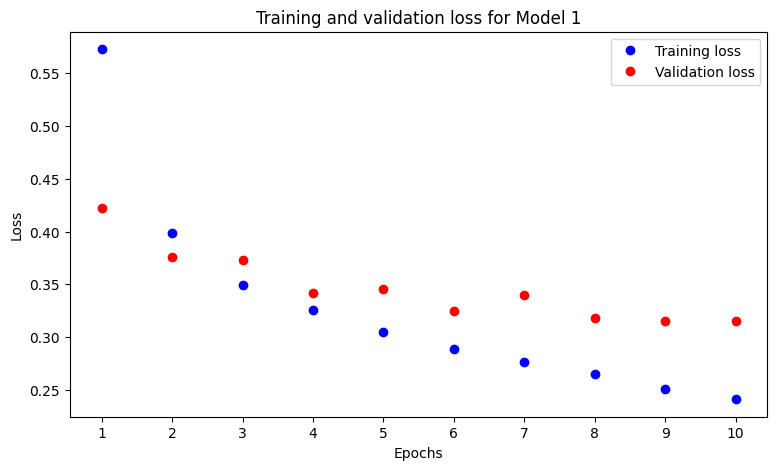

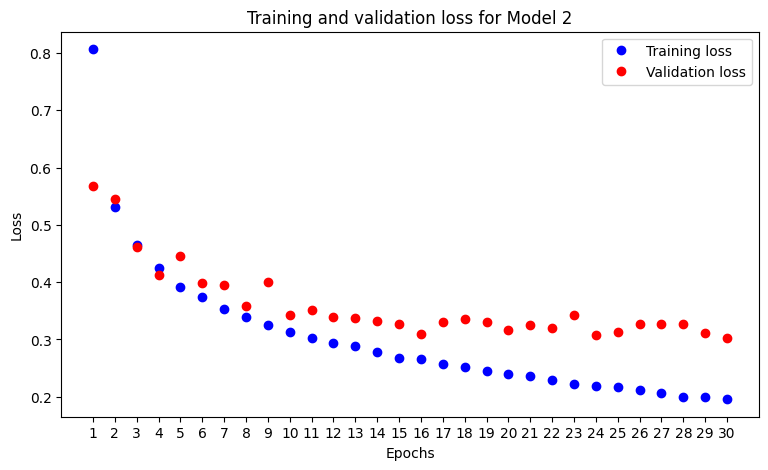

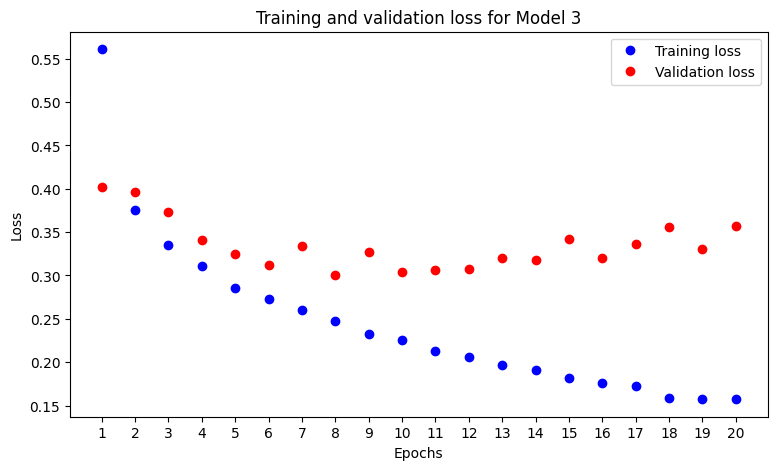

In [80]:
plot_training_val_loss(model_history)

## Plotting the Training and Validation Accuracy for each model

* From the Training and validation accuracy graph, For **Model 1**, the **validation accuracy is same at epoch 8 and epoch 10**. **The optimal epoch is 8 because at epoch 9, the model started to overfit.**
* Model 2, **the highest accuracy is at epoch 16, after which the validation accuracy started to fluctuate**. The **best weight** is **at epoch 16 for Model 2**.
* For **Model 3**, **the validation accuracy is highest at epoch 8 and epoch 12**. Out of the two epochs, **epoch 8 has the minimum loss**. so, the **beat epoch is 8 for Model 3**.

In [81]:
def plot_training_val_accuracy(model_history):
    for model,history in enumerate(model_history):
        history_dict = history.history
        plt.figure(figsize=(9, 5))
        acc_values = history_dict["accuracy"]
        val_acc_values = history_dict["val_accuracy"]
        epochs = range(1, len(acc_values) + 1)
        plt.plot(epochs, acc_values, "bo", label="Training accuracy")
        plt.plot(epochs, val_acc_values, "ro", label="Validation accuracy")
        plt.xlabel("Epochs")
        plt.xticks(epochs)
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title(f"Training and validation accuracy for Model {model+1}")

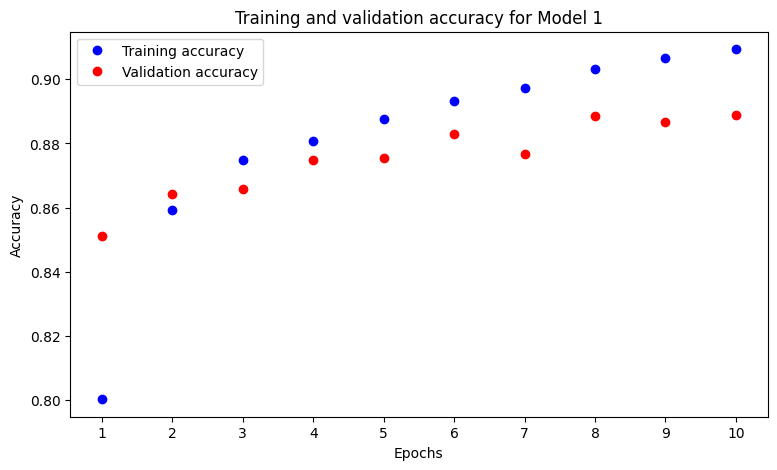

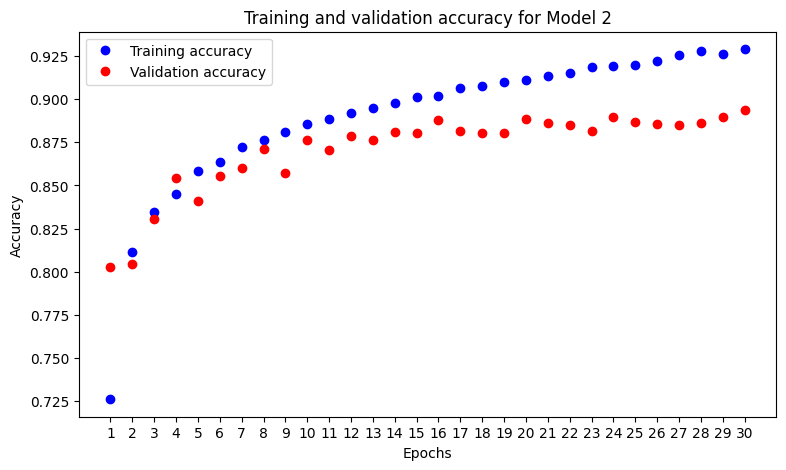

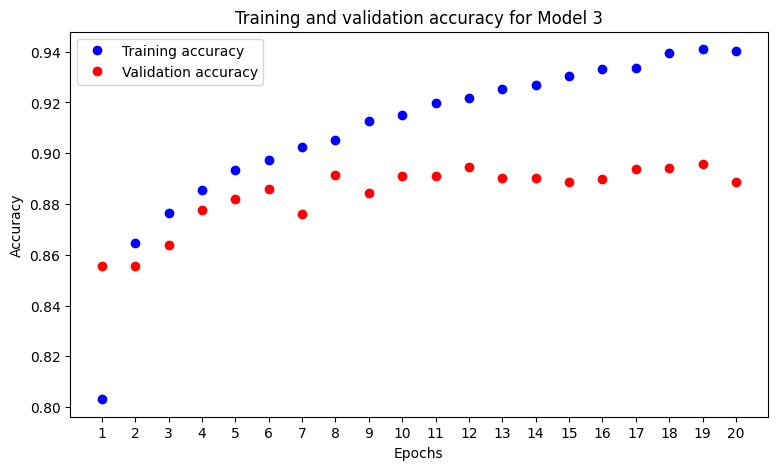

In [82]:
plot_training_val_accuracy(model_history)

## Choosing and Loading the best weights for the three models

From the above training and validation loss, accuracy graphs of the three models, we have **considered the epoch at which validation loss is minimum and validation accuracy is high** and we have selected the best epoch for each model using modelcheckpoint_callback method and saved the model in hdf5 format

In [149]:
best_weight_models = []
file_names = ['best_model1.hdf5','best_model2.hdf5','best_model3.hdf5']

In [150]:
# Loading the saved models with best weights
for file in file_names:
    best_model = load_model(file)
    best_weight_models.append(best_model)

In [151]:
final_val_summary_models = []
best_models_weight_val_summary = []

In [152]:
for model,history in enumerate(model_history):
    history_dict = history.history
    final_val_loss = history_dict["val_loss"][-1]
    final_val_accuracy = history_dict["val_accuracy"][-1]
    model_name = "Model "+str(model+1)
    final_val_summary_models.append([model_name,final_val_accuracy,final_val_loss])

In [153]:
# Evaluating the model with best weights on the validation dataset
for best_weight_model in best_weight_models:
    val_loss, val_acc = best_weight_model.evaluate(val_images, val_labels)
    best_models_weight_val_summary.append([val_acc,val_loss])

 28/375 [=>............................] - ETA: 0s - loss: 0.2897 - accuracy: 0.8940  

375/375 [==============================] - 1s 3ms/step - loss: 0.3011 - accuracy: 0.8915


In [154]:
df_final_val_summary_models = pd.DataFrame(final_val_summary_models,columns=["Model Name","Final Val Accuracy","Final Val Loss"])

In [155]:
val_summary = pd.DataFrame(best_models_weight_val_summary,columns = ["Best Epoch/weight Val accuracy","Best Epoch/Weight Model Val Loss"])
val_summary = pd.concat([df_final_val_summary_models,val_summary],axis=1)

In [156]:
val_summary

,Model Name,Final Val Accuracy,Final Val Loss,Best Epoch/weight Val accuracy,Best Epoch/Weight Model Val Loss
0,Model 1,0.888750,0.315169,0.886667,0.314907
1,Model 2,0.893833,0.302528,0.893833,0.302528
2,Model 3,0.888667,0.356588,0.891500,0.301107


## Evaluation on Validation Dataset with best weight models 

* We got an overall **accuracy of 89% approximately on the validation dataset** for the **best weights of all the three models**. 
* From the classification report, we can find that **all the three models** are **able to classify Class 1 - Trousers with higher precision and recall of almost 99% and 98%** respectively. 
* Also the models are able to classify **Class 5 - Sandals, Class 8 - Bag and Class 9 - Ankle Boot accurately**.
* The **three models struggles to recognize Class 2 - Pullover, Class 4 - Coat, Class 6 - Shirt** because all **the images in this class has similar features and structures**. So, the all the three models is finding it difficult to classify these classes. 

In [157]:
for model,best_weight_model in enumerate(best_weight_models):
    # Predicting the probablities of each class on the validation dataset
    val_pred_prob = best_weight_model.predict(val_images)
    # From the probabilities finding the class with the highest probability as predicted class label
    val_pred = np.argmax(val_pred_prob,axis = 1)
    # Generating the classification report for validation dataset
    validation_class_report = classification_report(val_labels,val_pred)
    print(f"Classification Report for Model {model+1} with best weights")
    print(validation_class_report)

 82/375 [=====>........................] - ETA: 0s

375/375 [==============================] - 1s 2ms/step
Classification Report for Model 1 with best weights
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1236
           1       0.98      0.98      0.98      1206
           2       0.77      0.85      0.81      1232
           3       0.91      0.89      0.90      1204
           4       0.82      0.80      0.81      1215
           5       0.95      0.96      0.95      1194
           6       0.78      0.62      0.69      1149
           7       0.93      0.94      0.94      1180
           8       0.96      0.97      0.97      1180
           9       0.95      0.95      0.95      1204

    accuracy                           0.89     12000
   macro avg       0.89      0.89      0.89     12000
weighted avg       0.89      0.89      0.89     12000

375/375 [==============================] - 1s 2ms/step
Classification Report for Model 2 with best weights
              precision    

## Choosing the best Model with best weights among the three models.

From the analysis above, we can come into conclusion the **validation accuracy of Model 3 is higher when compared to other models**. **Model 3 has two hidden layers and uses adam optimizer**. Also the **precision and recall for Class 4, 5 and 6 is higher in Model 3**. The **model 3 with two hidden layers is able to recognize classes shirt, pullover and coat to some extent when compared to other models**. 

## Evaluation on testing dataset with Model 3 - which is the best among the three

* We got an **overall accuracy of 88% on the testing dataset**.
* **Almost same accuracy in testing and validation dataset** implies that **the model generalizes well and pretty good in predicting the classes**. 
* In the testing dataset also **model struggles to recognize Class 2 - Pullover, Class 4 - Coat, Class 6 - Shirt** because all **the images in this class has similar features and structures**.

In [158]:
best_weight_model = load_model('best_model3.hdf5')

In [159]:
# Evaluating the model on the testing dataset
test_loss, test_acc = best_weight_model.evaluate(test_images, test_labels)
print(f"Testing dataset Accuracy: {test_acc}")

  1/313 [..............................] - ETA: 1:33 - loss: 0.3253 - accuracy: 0.8438

313/313 [==============================] - 1s 3ms/step - loss: 0.3311 - accuracy: 0.8848
Testing dataset Accuracy: 0.8848000168800354


In [161]:
# Predicting the probablities of each class on the testing dataset
test_pred_prob = best_weight_model.predict(test_images)

 75/313 [======>.......................] - ETA: 0s

313/313 [==============================] - 1s 3ms/step


In [162]:
# From the probabilities finding the class with the highest probability as predicted class label
test_pred = np.argmax(test_pred_prob,axis = 1)

In [163]:
# Generating the classification report for validation dataset
testing_class_report = classification_report(test_labels,test_pred)

In [165]:
# Printing the precision,recall,F1-score, support for each class along with Overall accuracy on testing set
print("Classification Report of the best Model 3 with best weights on testing dataset")
print(testing_class_report)

Classification Report of the best Model 3 with best weights on testing dataset
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.78      0.81      0.80      1000
           3       0.88      0.89      0.88      1000
           4       0.79      0.81      0.80      1000
           5       0.96      0.96      0.96      1000
           6       0.76      0.65      0.70      1000
           7       0.95      0.94      0.94      1000
           8       0.97      0.98      0.97      1000
           9       0.95      0.96      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



### Increasing the precision of Class 5 - Sandals

Already the **precision of Class 5 - Sandals is 0.96 and recall is 0.96 on validation dataset for Model 3**. At **custom threshold 0.8885673**, the **precision is increased to 0.99 but the recall decresed to 0.94**

In [183]:
# Choose one image class 5 - Sandals
positive_class = 5
binary_labels = []

In [184]:
# Converting it as binary labels 5-Sanadals and Not Sandals
for class_label in val_labels:
    if class_label == positive_class:
        binary_labels.append(1)
    else:
        binary_labels.append(0)

In [185]:
# converting list of labels into array
val_pred_5 = np.array(binary_labels)

In [186]:
# getting the predicted probabilities of the model for Class 5
val_pred_prob_class5 = val_pred_prob[:, 5]

In [187]:
# printing the predicted probabilities of the model for class 5
val_pred_prob_class5

array([9.9994826e-01, 2.3296470e-04, 3.8802742e-08, ..., 5.3385328e-08,
       4.9669879e-06, 1.0000000e+00], dtype=float32)

In [188]:
# Calculating the precision, recall and threshold of Class 5 - sandals
precisions, recalls, thresholds = precision_recall_curve(
    val_pred_5, val_pred_prob_class5)

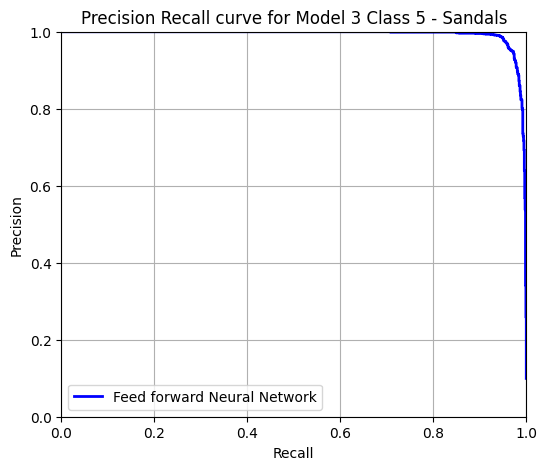

In [189]:
# Plotting the precision recall curve
plt.figure(figsize=(6, 5))

plt.plot(recalls, precisions, "b-", linewidth=2,
         label="Feed forward Neural Network")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.title("Precision Recall curve for Model 3 Class 5 - Sandals")
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [190]:
# finding the threshold at which precision is 99%
idx_for_99_precision = (precisions >= 0.99).argmax()
threshold_for_99_precision = thresholds[idx_for_99_precision]
print("Threshold value at which precision is greater than 99% ", threshold_for_99_precision)

Threshold value at which precision is greater than 99%  0.8885673


In [191]:
# Adjusting the class predictions based on the new threshold
val_pred_99_precision = (val_pred_prob_class5 >= threshold_for_99_precision)

In [192]:
# recalculated precision
precision_score(val_pred_5,val_pred_99_precision)

0.9903169014084507

In [193]:
# recalculated recall
recall_score(val_pred_5,val_pred_99_precision)

0.9422110552763819

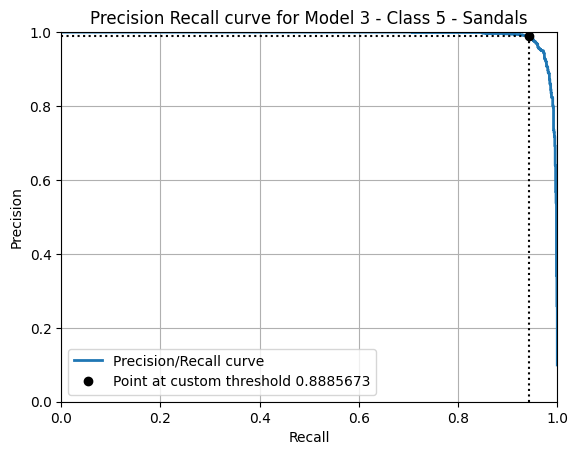

In [194]:
# Plotting precision recall curve for Class 5- Sandals at custom threshold
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.plot([recalls[idx_for_99_precision], recalls[idx_for_99_precision]], [0., precisions[idx_for_99_precision]], "k:")
plt.plot([0.0, recalls[idx_for_99_precision]], [precisions[idx_for_99_precision], precisions[idx_for_99_precision]], "k:")
plt.plot([recalls[idx_for_99_precision]], [precisions[idx_for_99_precision]], "ko",
         label="Point at custom threshold 0.8885673")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall curve for Model 3 - Class 5 - Sandals")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

### Increasing the recall of Class 5 - Sandals

When trying to **increase the recall from 0.96 to 1.0**, the **precision decreased to 0.0995** which is not acceptable

In [199]:
# finding the threshold at which recall is greater than 98%
idx_for_99_recall = (recalls >= 0.98).argmax()
threshold_for_99_recall = thresholds[idx_for_99_recall]
print("Threshold value at which recall is greater than 98% ", threshold_for_99_recall)

Threshold value at which recall is greater than 98%  1.5861728e-20


In [200]:
# Adjusting the values based on the new threshold at which recall is greater than 98%
val_pred_99_recall = (val_pred_prob_class5 >= threshold_for_99_recall)

In [201]:
# recalculating the precision
precision_score(val_pred_5,val_pred_99_recall)

0.0995

In [202]:
# recalculating the recall
recall_score(val_pred_5,val_pred_99_recall)

1.0

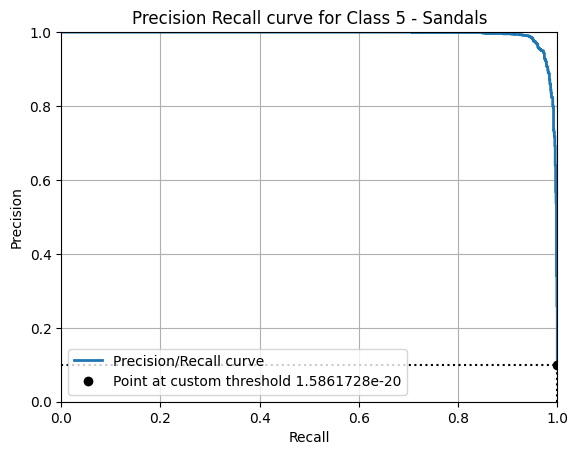

In [203]:
# Plotting precision recall curve for Model 3 - Class 5 - Sandals at custom threshold
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.plot([recalls[idx_for_99_recall], recalls[idx_for_99_recall]], [0., precisions[idx_for_99_recall]], "k:")
plt.plot([0.0, recalls[idx_for_99_recall]], [precisions[idx_for_99_recall], precisions[idx_for_99_recall]], "k:")
plt.plot([recalls[idx_for_99_recall]], [precisions[idx_for_99_recall]], "ko",
         label="Point at custom threshold 1.5861728e-20")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall curve for Class 5 - Sandals")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()


## Conclusion

* To summarize, the **classes in dataset is balanced with 0 skewness**. 
* We have **defined and trained three different fully connected neural networks** with **different hyperparameters**.
* Evaluated the three models on validation dataset, **analysed the validation loss and accuracy of the three models and found the best weights for the three models before it start to overfit the dataset**.
* From the analysis, **Model 3 with two hidden layers** has **minimum validation loss** and **maximum validation accuracy**.
* The **best Model 3** has a **training accuracy of 94%** and **validation accuracy of 89%**. **Testing accuracy is 88**% 
* It produces **similar accuracy of almost 89% on both validation and testing dataset** which implies that the **model 3 generalizes well and is able to classify fashion clothing classes**. 
* But **model struggles to classify pullover, shirt and coat due to similar features and structures**.